# This is just a playground for me 

In [5]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
from warnings import filterwarnings
filterwarnings("ignore") 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :2] 
        Y_locations = X[:, 2:4] 
        Z_locations = X[:, 4:6]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 2:4].assign(X[:, 2:4] + mask * tf.ones_like(X[:, 2:4]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 2:4].assign(X[:, 2:4] - mask * tf.ones_like(X[:, 2:4]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :2].assign(X[:, :2] + mask * tf.ones_like(X[:, :2]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :2].assign(X[:, :2] - mask * tf.ones_like(X[:, :2]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 4:6].assign(X[:, 4:6] + mask * tf.ones_like(X[:, 4:6]) * move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 4:6].assign(X[:, 4:6] - mask * tf.ones_like(X[:, 4:6]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
    
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(**kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give the 0th landmark"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence)  
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 2
    Y_locations = [0] * 2
    Z_locations = [0] * 2
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[hand] = landmark.x
                Y_locations[hand] = landmark.y
                Z_locations[hand] = landmark.z
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 3))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations) 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [2]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('one_point_folds'): 
    with open(f"one_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)
X = np.nan_to_num(X)

In [55]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (With Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (With Aug)")
    plt.show()

In [41]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [20]:
import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 6)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y)

using seed 52


In [42]:
def make_model(): 
    model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (None, 6)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

Epoch 1/75
3/3 [==============================] - 2s 391ms/step - loss: 0.6946 - accuracy: 0.4000 - precision_133: 0.4314 - recall_133: 0.5366 - val_loss: 0.6881 - val_accuracy: 0.4500 - val_precision_133: 0.4500 - val_recall_133: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 339ms/step - loss: 0.6705 - accuracy: 0.5375 - precision_133: 0.5323 - recall_133: 0.8049 - val_loss: 0.6803 - val_accuracy: 0.4000 - val_precision_133: 0.2000 - val_recall_133: 0.1111
Epoch 3/75
3/3 [==============================] - 1s 367ms/step - loss: 0.6711 - accuracy: 0.5250 - precision_133: 0.5385 - recall_133: 0.5122 - val_loss: 0.6660 - val_accuracy: 0.5500 - val_precision_133: 0.5000 - val_recall_133: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6487 - accuracy: 0.6000 - precision_133: 0.5652 - recall_133: 0.9512 - val_loss: 0.6816 - val_accuracy: 0.4500 - val_precision_133: 0.4500 - val_recall_133: 1.0000
Epoch 5/75
3/3 [==============================] 

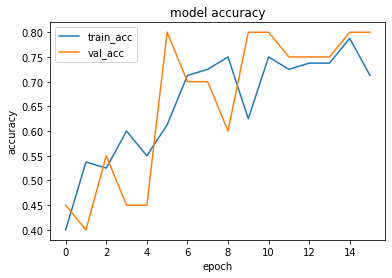

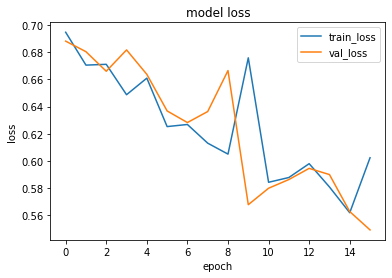

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.4891521]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5086132]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.51491505]]


1it [00:00, 13662.23it/s]


prediction for video control_1.mov is [[0.47880578]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.47327143]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.4725257]]
Epoch 1/75
3/3 [==============================] - 1s 347ms/step - loss: 0.7034 - accuracy: 0.5250 - precision_134: 0.5000 - recall_134: 0.2368 - val_loss: 0.6937 - val_accuracy: 0.4500 - val_precision_134: 0.6000 - val_recall_134: 0.2500
Epoch 2/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6932 - accuracy: 0.5500 - precision_134: 0.5500 - recall_134: 0.2895 - val_loss: 0.6741 - val_accuracy: 0.7000 - val_precision_134: 0.8000 - val_recall_134: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 404ms/step - loss: 0.6697 - accuracy: 0.6250 - precision_134: 0.6429 - recall_134: 0.4737 - val_loss: 0.6578 - val_accuracy: 0.6000 - val_precision_134: 0.8333 - val_recall_134: 0.4167
Epoch 4/75
3/3 [==============================] - 1s 379ms/step - loss: 0.6320 - accuracy: 0.7125 - precision_134: 0.7586 - recall_134: 0.5789 - val_loss: 0.5553 - val_accuracy: 0.7000 - val_precision_134: 0.6875 - val_recall_134: 0.9

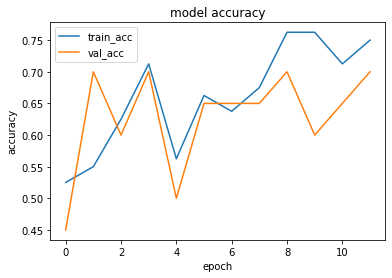

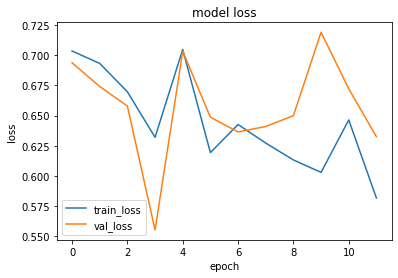

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.39232013]]


1it [00:00, 11915.64it/s]


prediction for video armflapping_3.mov is [[0.5213711]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_2.mov is [[0.59202784]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.29843202]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.2796056]]


1it [00:00, 15196.75it/s]


prediction for video control_3.mov is [[0.28167155]]
Epoch 1/75
3/3 [==============================] - 1s 350ms/step - loss: 0.6857 - accuracy: 0.5625 - precision_135: 0.5676 - recall_135: 0.5250 - val_loss: 0.6670 - val_accuracy: 0.7500 - val_precision_135: 0.7273 - val_recall_135: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 344ms/step - loss: 0.6701 - accuracy: 0.5750 - precision_135: 0.5517 - recall_135: 0.8000 - val_loss: 0.6412 - val_accuracy: 0.7500 - val_precision_135: 0.6923 - val_recall_135: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 361ms/step - loss: 0.6674 - accuracy: 0.6500 - precision_135: 0.6304 - recall_135: 0.7250 - val_loss: 0.6090 - val_accuracy: 0.6500 - val_precision_135: 1.0000 - val_recall_135: 0.3000
Epoch 4/75
3/3 [==============================] - 1s 418ms/step - loss: 0.6706 - accuracy: 0.5500 - precision_135: 0.6429 - recall_135: 0.2250 - val_loss: 0.6019 - val_accuracy: 0.8000 - val_precision_135: 1.0000 - val_recall_135: 0.

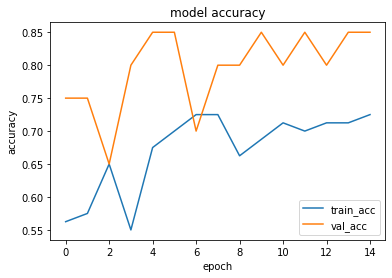

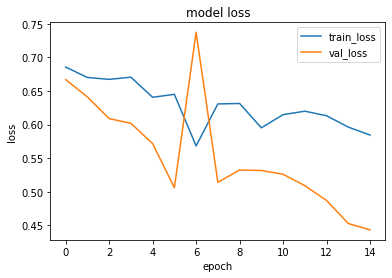

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.48233923]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.5146888]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5209569]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.46295977]]


1it [00:00, 13357.66it/s]


prediction for video control_2.mov is [[0.45358846]]


1it [00:00, 16644.06it/s]


prediction for video control_3.mov is [[0.4514384]]
Epoch 1/75
3/3 [==============================] - 1s 316ms/step - loss: 0.7022 - accuracy: 0.4375 - precision_136: 0.3913 - recall_136: 0.2250 - val_loss: 0.6891 - val_accuracy: 0.5500 - val_precision_136: 0.5714 - val_recall_136: 0.4000
Epoch 2/75
3/3 [==============================] - 1s 462ms/step - loss: 0.6782 - accuracy: 0.6875 - precision_136: 0.7143 - recall_136: 0.6250 - val_loss: 0.6817 - val_accuracy: 0.5000 - val_precision_136: 0.5000 - val_recall_136: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6787 - accuracy: 0.5000 - precision_136: 0.5000 - recall_136: 0.9250 - val_loss: 0.6733 - val_accuracy: 0.5000 - val_precision_136: 0.5000 - val_recall_136: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 351ms/step - loss: 0.6314 - accuracy: 0.7125 - precision_136: 0.6667 - recall_136: 0.8500 - val_loss: 0.6862 - val_accuracy: 0.6000 - val_precision_136: 0.5833 - val_recall_136: 0.7

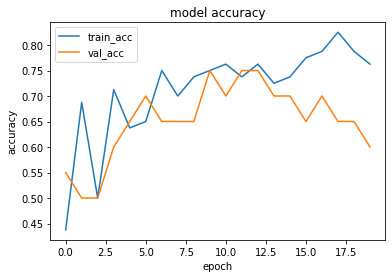

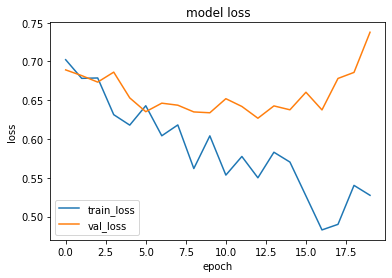

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.20370296]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.7301343]]


1it [00:00, 7049.25it/s]


prediction for video armflapping_2.mov is [[0.7470855]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.1619806]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.15324968]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.16505998]]
Epoch 1/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6920 - accuracy: 0.4500 - precision_137: 0.4694 - recall_137: 0.5610 - val_loss: 0.6940 - val_accuracy: 0.4000 - val_precision_137: 0.4000 - val_recall_137: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 338ms/step - loss: 0.6674 - accuracy: 0.5750 - precision_137: 0.5479 - recall_137: 0.9756 - val_loss: 0.6826 - val_accuracy: 0.5000 - val_precision_137: 0.4737 - val_recall_137: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6679 - accuracy: 0.6125 - precision_137: 0.6000 - recall_137: 0.7317 - val_loss: 0.6514 - val_accuracy: 0.6000 - val_precision_137: 0.5455 - val_recall_137: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6594 - accuracy: 0.6625 - precision_137: 0.6591 - recall_137: 0.7073 - val_loss: 0.6507 - val_accuracy: 0.6000 - val_precision_137: 0.5385 - val_recall_137: 0.

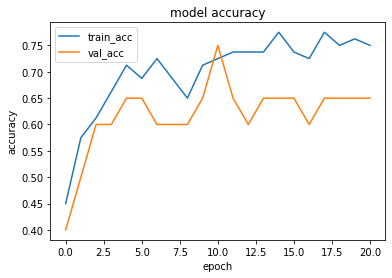

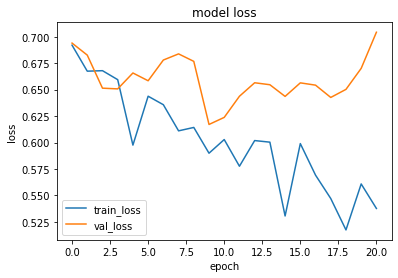

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.6185296]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.5324268]]


1it [00:00, 8272.79it/s]


prediction for video armflapping_2.mov is [[0.66002196]]


1it [00:00, 16644.06it/s]


prediction for video control_1.mov is [[0.35098666]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.30154788]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.28562683]]


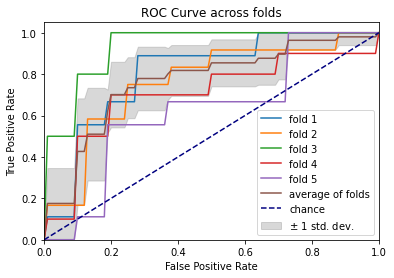

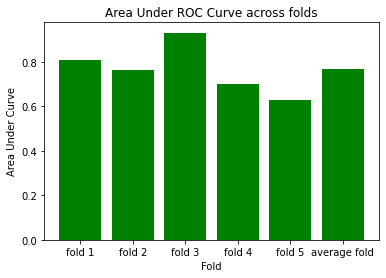

In [43]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 319ms/step - loss: 0.7045 - accuracy: 0.5750 - precision_139: 0.5556 - recall_139: 0.8537 - val_loss: 0.6772 - val_accuracy: 0.6500 - val_precision_139: 0.6000 - val_recall_139: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6872 - accuracy: 0.6000 - precision_139: 0.6552 - recall_139: 0.4634 - val_loss: 0.6805 - val_accuracy: 0.5500 - val_precision_139: 0.5000 - val_recall_139: 0.1111
Epoch 3/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6650 - accuracy: 0.6125 - precision_139: 0.8571 - recall_139: 0.2927 - val_loss: 0.6766 - val_accuracy: 0.5500 - val_precision_139: 0.5000 - val_recall_139: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6608 - accuracy: 0.5875 - precision_139: 0.5645 - recall_139: 0.8537 - val_loss: 0.6880 - val_accuracy: 0.4500 - val_precision_139: 0.4500 - val_recall_139: 1.0000
Epoch 5/75
3/3 [==============================] 

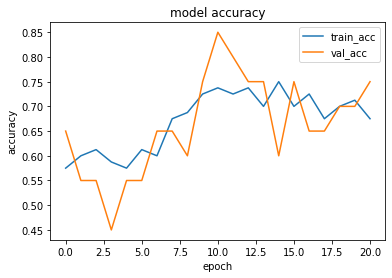

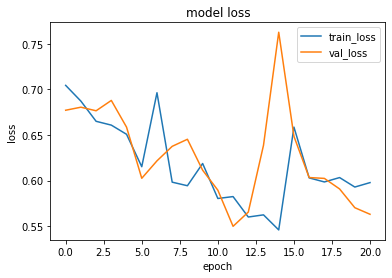

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.44004264]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.51246035]]


1it [00:00, 10538.45it/s]


prediction for video armflapping_2.mov is [[0.53359115]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.39952856]]


1it [00:00, 14027.77it/s]


prediction for video control_2.mov is [[0.38729453]]


1it [00:00, 12483.05it/s]


prediction for video control_3.mov is [[0.37989575]]
Epoch 1/75
3/3 [==============================] - 1s 354ms/step - loss: 0.6885 - accuracy: 0.5875 - precision_140: 0.6316 - recall_140: 0.3158 - val_loss: 0.6858 - val_accuracy: 0.5000 - val_precision_140: 1.0000 - val_recall_140: 0.1667
Epoch 2/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6644 - accuracy: 0.6125 - precision_140: 0.7059 - recall_140: 0.3158 - val_loss: 0.6952 - val_accuracy: 0.5500 - val_precision_140: 1.0000 - val_recall_140: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 324ms/step - loss: 0.7501 - accuracy: 0.6000 - precision_140: 0.6364 - recall_140: 0.3684 - val_loss: 0.6242 - val_accuracy: 0.7000 - val_precision_140: 0.8750 - val_recall_140: 0.5833
Epoch 4/75
3/3 [==============================] - 1s 347ms/step - loss: 0.6505 - accuracy: 0.7375 - precision_140: 0.6735 - recall_140: 0.8684 - val_loss: 0.6345 - val_accuracy: 0.7500 - val_precision_140: 0.7692 - val_recall_140: 0.

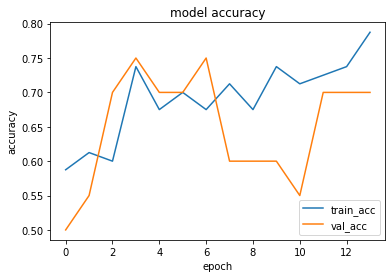

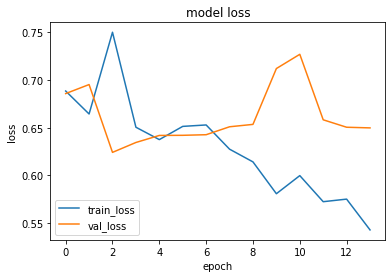

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.6099033]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.68328035]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.71175843]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.28282887]]


1it [00:00, 14027.77it/s]


prediction for video control_2.mov is [[0.22966754]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.35448062]]
Epoch 1/75
3/3 [==============================] - 1s 293ms/step - loss: 0.7004 - accuracy: 0.4125 - precision_141: 0.4340 - recall_141: 0.5750 - val_loss: 0.6886 - val_accuracy: 0.5000 - val_precision_141: 0.5000 - val_recall_141: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 284ms/step - loss: 0.6771 - accuracy: 0.5625 - precision_141: 0.5362 - recall_141: 0.9250 - val_loss: 0.6769 - val_accuracy: 0.7500 - val_precision_141: 0.6923 - val_recall_141: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6780 - accuracy: 0.6375 - precision_141: 0.6038 - recall_141: 0.8000 - val_loss: 0.6678 - val_accuracy: 0.7500 - val_precision_141: 0.6923 - val_recall_141: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6762 - accuracy: 0.6000 - precision_141: 0.5952 - recall_141: 0.6250 - val_loss: 0.6416 - val_accuracy: 0.8000 - val_precision_141: 0.8000 - val_recall_141: 0.

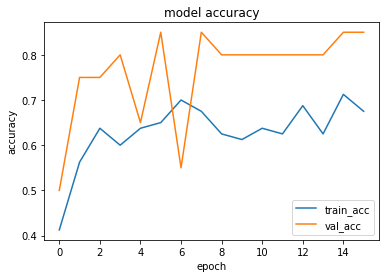

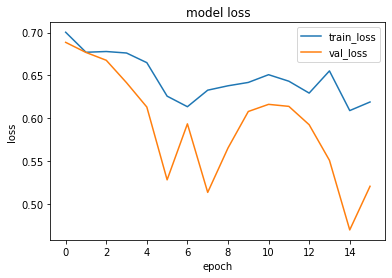

1it [00:00, 13934.56it/s]


prediction for video armflapping_1.mov is [[0.45419]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.52941847]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.55981714]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.3888633]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.36475134]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.35302854]]
Epoch 1/75
3/3 [==============================] - 1s 294ms/step - loss: 0.7124 - accuracy: 0.5000 - precision_142: 0.5000 - recall_142: 0.1250 - val_loss: 0.6933 - val_accuracy: 0.4500 - val_precision_142: 0.0000e+00 - val_recall_142: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6932 - accuracy: 0.5250 - precision_142: 0.5208 - recall_142: 0.6250 - val_loss: 0.6847 - val_accuracy: 0.5000 - val_precision_142: 0.5000 - val_recall_142: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6742 - accuracy: 0.5750 - precision_142: 0.5484 - recall_142: 0.8500 - val_loss: 0.6716 - val_accuracy: 0.5500 - val_precision_142: 0.5294 - val_recall_142: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6284 - accuracy: 0.5625 - precision_142: 0.5410 - recall_142: 0.8250 - val_loss: 0.6452 - val_accuracy: 0.5500 - val_precision_142: 0.5294 - val_recall

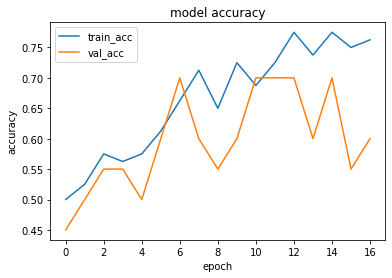

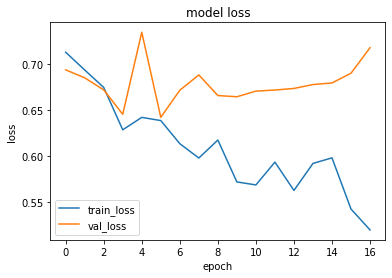

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.3759112]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.6212548]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.6792544]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.17595759]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.15095434]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.20647499]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6983 - accuracy: 0.4750 - precision_143: 0.4898 - recall_143: 0.5854 - val_loss: 0.6845 - val_accuracy: 0.6000 - val_precision_143: 0.5385 - val_recall_143: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6779 - accuracy: 0.6875 - precision_143: 0.7353 - recall_143: 0.6098 - val_loss: 0.6673 - val_accuracy: 0.6000 - val_precision_143: 0.5385 - val_recall_143: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6547 - accuracy: 0.6875 - precision_143: 0.6333 - recall_143: 0.9268 - val_loss: 0.7070 - val_accuracy: 0.5000 - val_precision_143: 0.4706 - val_recall_143: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 282ms/step - loss: 0.6285 - accuracy: 0.5875 - precision_143: 0.5588 - recall_143: 0.9268 - val_loss: 0.6531 - val_accuracy: 0.6000 - val_precision_143: 0.5385 - val_recall_143: 0.

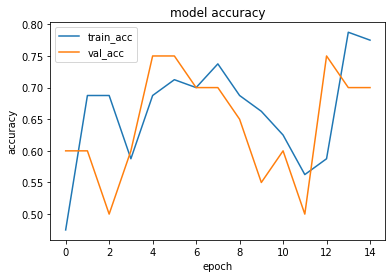

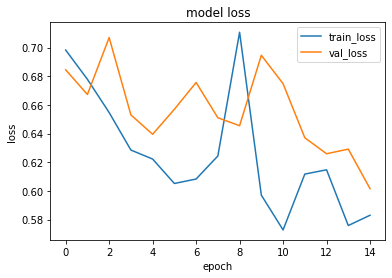

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.44525245]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.53108615]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5903851]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.40346017]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.38689685]]


1it [00:00, 6797.90it/s]


prediction for video control_3.mov is [[0.3849802]]


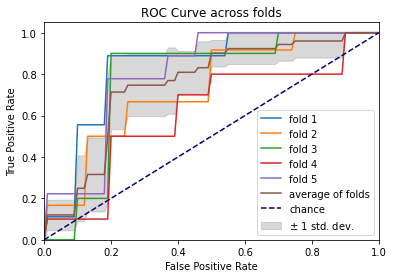

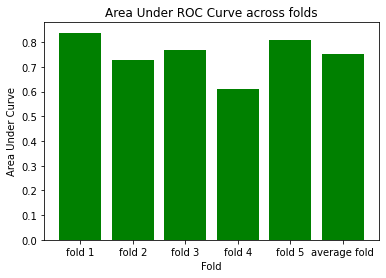

In [44]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6848 - accuracy: 0.5875 - precision_145: 0.6250 - recall_145: 0.4878 - val_loss: 0.6686 - val_accuracy: 0.7500 - val_precision_145: 0.6667 - val_recall_145: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6472 - accuracy: 0.7000 - precision_145: 0.7073 - recall_145: 0.7073 - val_loss: 0.6512 - val_accuracy: 0.5000 - val_precision_145: 0.4737 - val_recall_145: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6346 - accuracy: 0.6000 - precision_145: 0.5672 - recall_145: 0.9268 - val_loss: 0.6009 - val_accuracy: 0.7500 - val_precision_145: 0.6667 - val_recall_145: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6285 - accuracy: 0.7125 - precision_145: 0.7143 - recall_145: 0.7317 - val_loss: 0.6284 - val_accuracy: 0.6500 - val_precision_145: 0.5625 - val_recall_145: 1.0000
Epoch 5/75
3/3 [==============================] 

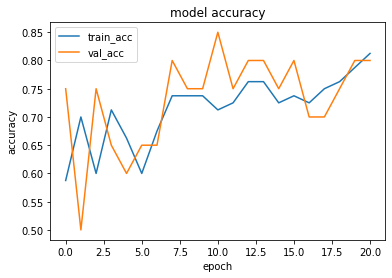

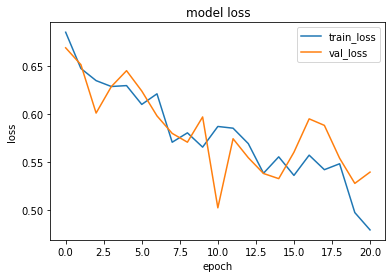

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.53048444]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5790156]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.5116219]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.51931816]]


1it [00:00, 12483.05it/s]


prediction for video control_2.mov is [[0.48362517]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.49494916]]
Epoch 1/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6947 - accuracy: 0.5000 - precision_146: 0.4792 - recall_146: 0.6053 - val_loss: 0.6876 - val_accuracy: 0.6000 - val_precision_146: 0.6250 - val_recall_146: 0.8333
Epoch 2/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6680 - accuracy: 0.6375 - precision_146: 0.5957 - recall_146: 0.7368 - val_loss: 0.6722 - val_accuracy: 0.6000 - val_precision_146: 0.8333 - val_recall_146: 0.4167
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6417 - accuracy: 0.6500 - precision_146: 0.6136 - recall_146: 0.7105 - val_loss: 0.7168 - val_accuracy: 0.6500 - val_precision_146: 1.0000 - val_recall_146: 0.4167
Epoch 4/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6199 - accuracy: 0.7500 - precision_146: 0.7647 - recall_146: 0.6842 - val_loss: 0.6756 - val_accuracy: 0.6000 - val_precision_146: 0.7500 - val_recall_146: 0.

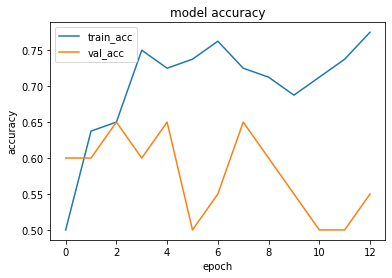

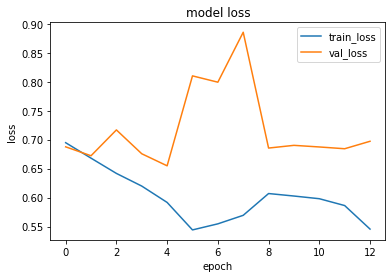

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.3634569]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.4464935]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5542899]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.3222126]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.31242937]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.3056006]]
Epoch 1/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6961 - accuracy: 0.4375 - precision_147: 0.4561 - recall_147: 0.6500 - val_loss: 0.6688 - val_accuracy: 0.6000 - val_precision_147: 0.5556 - val_recall_147: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6811 - accuracy: 0.5250 - precision_147: 0.5143 - recall_147: 0.9000 - val_loss: 0.6497 - val_accuracy: 0.6000 - val_precision_147: 0.5556 - val_recall_147: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 284ms/step - loss: 0.6750 - accuracy: 0.5625 - precision_147: 0.5333 - recall_147: 1.0000 - val_loss: 0.5984 - val_accuracy: 0.6500 - val_precision_147: 0.5882 - val_recall_147: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6561 - accuracy: 0.5500 - precision_147: 0.5385 - recall_147: 0.7000 - val_loss: 0.5752 - val_accuracy: 0.9500 - val_precision_147: 1.0000 - val_recall_147: 0.9

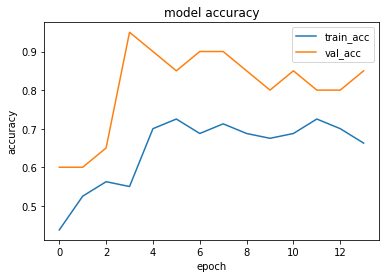

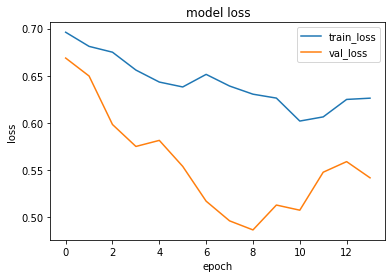

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.4980637]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.50416565]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.5226073]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.4862424]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.48158222]]


1it [00:00, 12826.62it/s]


prediction for video control_3.mov is [[0.4802822]]
Epoch 1/75
3/3 [==============================] - 1s 340ms/step - loss: 0.7019 - accuracy: 0.4750 - precision_148: 0.4828 - recall_148: 0.7000 - val_loss: 0.6893 - val_accuracy: 0.5000 - val_precision_148: 0.5000 - val_recall_148: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 340ms/step - loss: 0.6774 - accuracy: 0.5250 - precision_148: 0.5152 - recall_148: 0.8500 - val_loss: 0.6850 - val_accuracy: 0.5000 - val_precision_148: 0.5000 - val_recall_148: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6686 - accuracy: 0.5750 - precision_148: 0.5417 - recall_148: 0.9750 - val_loss: 0.6752 - val_accuracy: 0.5500 - val_precision_148: 0.5294 - val_recall_148: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6422 - accuracy: 0.5625 - precision_148: 0.5385 - recall_148: 0.8750 - val_loss: 0.6992 - val_accuracy: 0.6000 - val_precision_148: 0.6250 - val_recall_148: 0.5

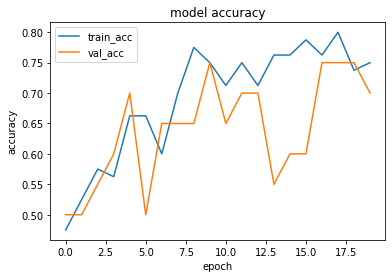

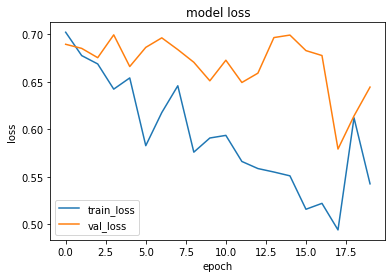

1it [00:00, 10951.19it/s]


prediction for video armflapping_1.mov is [[0.42098022]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.6796459]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.6937276]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.31890228]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.2700897]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.29789108]]
Epoch 1/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6947 - accuracy: 0.5250 - precision_149: 0.6000 - recall_149: 0.2195 - val_loss: 0.6745 - val_accuracy: 0.5000 - val_precision_149: 0.4737 - val_recall_149: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6691 - accuracy: 0.5875 - precision_149: 0.5571 - recall_149: 0.9512 - val_loss: 0.6558 - val_accuracy: 0.5000 - val_precision_149: 0.4737 - val_recall_149: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 333ms/step - loss: 0.6138 - accuracy: 0.6000 - precision_149: 0.5692 - recall_149: 0.9024 - val_loss: 0.6837 - val_accuracy: 0.6500 - val_precision_149: 0.5714 - val_recall_149: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 346ms/step - loss: 0.7152 - accuracy: 0.6500 - precision_149: 0.6667 - recall_149: 0.6341 - val_loss: 0.6344 - val_accuracy: 0.6000 - val_precision_149: 0.5385 - val_recall_149: 0.

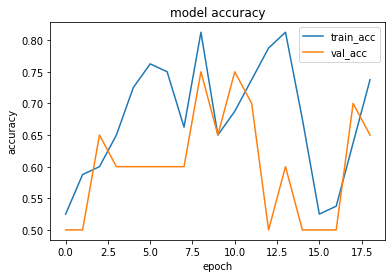

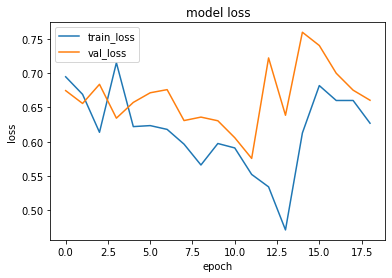

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.4961218]]


1it [00:00, 7145.32it/s]


prediction for video armflapping_3.mov is [[0.57883483]]


1it [00:00, 9709.04it/s]


prediction for video armflapping_2.mov is [[0.52587897]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.47223318]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.46133995]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.46331576]]


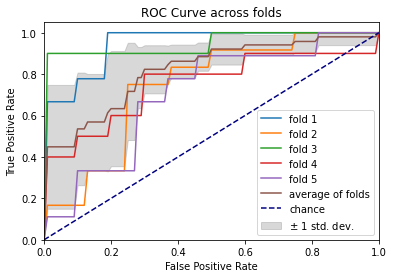

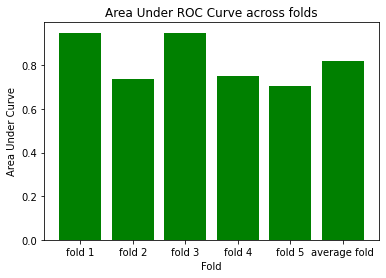

In [45]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6901 - accuracy: 0.5375 - precision_151: 0.5333 - recall_151: 0.7805 - val_loss: 0.6811 - val_accuracy: 0.4500 - val_precision_151: 0.4500 - val_recall_151: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 319ms/step - loss: 0.6807 - accuracy: 0.4500 - precision_151: 0.4483 - recall_151: 0.3171 - val_loss: 0.6619 - val_accuracy: 0.7500 - val_precision_151: 0.6667 - val_recall_151: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6247 - accuracy: 0.7250 - precision_151: 0.7209 - recall_151: 0.7561 - val_loss: 0.7246 - val_accuracy: 0.5000 - val_precision_151: 0.4737 - val_recall_151: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6502 - accuracy: 0.6000 - precision_151: 0.5652 - recall_151: 0.9512 - val_loss: 0.6039 - val_accuracy: 0.6500 - val_precision_151: 0.5714 - val_recall_151: 0.8889
Epoch 5/75
3/3 [==============================] 

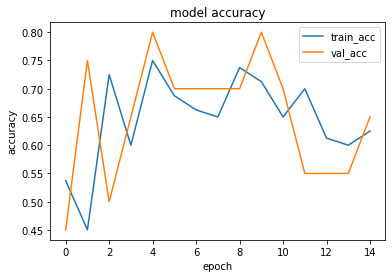

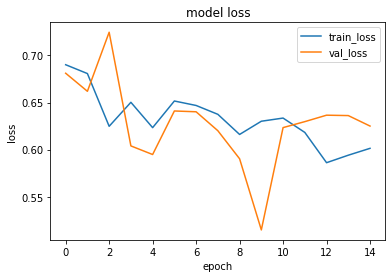

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.4696649]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.47541186]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.5156259]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.44287017]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.4315796]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.42617264]]
Epoch 1/75
3/3 [==============================] - 1s 337ms/step - loss: 0.6920 - accuracy: 0.5375 - precision_152: 0.5077 - recall_152: 0.8684 - val_loss: 0.6871 - val_accuracy: 0.5500 - val_precision_152: 0.8000 - val_recall_152: 0.3333
Epoch 2/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6918 - accuracy: 0.5125 - precision_152: 0.4706 - recall_152: 0.2105 - val_loss: 0.6940 - val_accuracy: 0.4000 - val_precision_152: 0.0000e+00 - val_recall_152: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6653 - accuracy: 0.6125 - precision_152: 0.6296 - recall_152: 0.4474 - val_loss: 0.6421 - val_accuracy: 0.6500 - val_precision_152: 0.7778 - val_recall_152: 0.5833
Epoch 4/75
3/3 [==============================] - 1s 350ms/step - loss: 0.6076 - accuracy: 0.7500 - precision_152: 0.7143 - recall_152: 0.7895 - val_loss: 0.7515 - val_accuracy: 0.5500 - val_precision_152: 0.8000 - val_recall

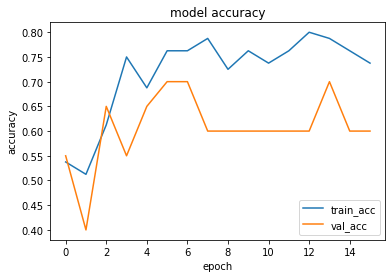

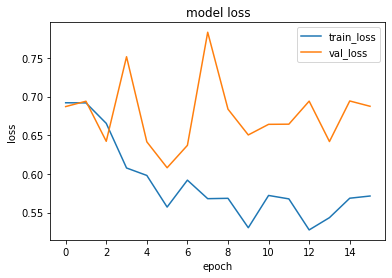

1it [00:00, 13486.51it/s]


prediction for video armflapping_1.mov is [[0.3522094]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.42329672]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.5039019]]


1it [00:00, 13486.51it/s]


prediction for video control_1.mov is [[0.32318193]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.30386868]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.30250615]]
Epoch 1/75
3/3 [==============================] - 1s 378ms/step - loss: 0.7135 - accuracy: 0.5000 - precision_153: 0.5000 - recall_153: 0.0500 - val_loss: 0.6816 - val_accuracy: 0.5500 - val_precision_153: 1.0000 - val_recall_153: 0.1000
Epoch 2/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6858 - accuracy: 0.5250 - precision_153: 0.5179 - recall_153: 0.7250 - val_loss: 0.6697 - val_accuracy: 0.5000 - val_precision_153: 0.5000 - val_recall_153: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6776 - accuracy: 0.5125 - precision_153: 0.5063 - recall_153: 1.0000 - val_loss: 0.6357 - val_accuracy: 0.7500 - val_precision_153: 0.6923 - val_recall_153: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6801 - accuracy: 0.6375 - precision_153: 0.6078 - recall_153: 0.7750 - val_loss: 0.5931 - val_accuracy: 0.9000 - val_precision_153: 1.0000 - val_recall_153: 0.

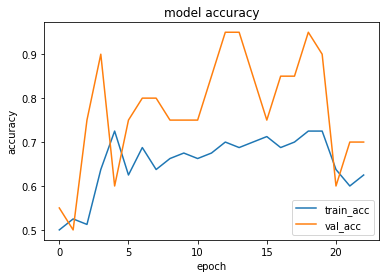

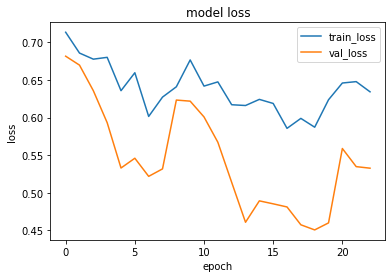

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.4949022]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_3.mov is [[0.51782584]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.55670494]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.4571216]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.44155052]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.4339204]]
Epoch 1/75
3/3 [==============================] - 1s 371ms/step - loss: 0.6816 - accuracy: 0.5375 - precision_154: 0.5263 - recall_154: 0.7500 - val_loss: 0.6830 - val_accuracy: 0.5500 - val_precision_154: 0.5556 - val_recall_154: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 383ms/step - loss: 0.6799 - accuracy: 0.6000 - precision_154: 0.6667 - recall_154: 0.4000 - val_loss: 0.6741 - val_accuracy: 0.6000 - val_precision_154: 0.6000 - val_recall_154: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6088 - accuracy: 0.7250 - precision_154: 0.6800 - recall_154: 0.8500 - val_loss: 0.7931 - val_accuracy: 0.5000 - val_precision_154: 0.5000 - val_recall_154: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 320ms/step - loss: 0.5933 - accuracy: 0.7000 - precision_154: 0.6481 - recall_154: 0.8750 - val_loss: 0.6823 - val_accuracy: 0.6500 - val_precision_154: 0.7143 - val_recall_154: 0.5

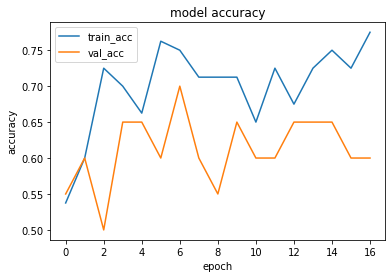

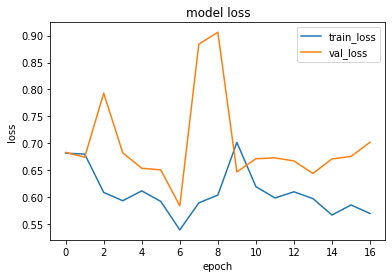

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.27932376]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5968378]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.6618982]]


1it [00:00, 12052.60it/s]


prediction for video control_1.mov is [[0.2149964]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.20503199]]


1it [00:00, 13934.56it/s]


prediction for video control_3.mov is [[0.2040683]]
Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6998 - accuracy: 0.4125 - precision_155: 0.2500 - recall_155: 0.0732 - val_loss: 0.6890 - val_accuracy: 0.5000 - val_precision_155: 0.4737 - val_recall_155: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 314ms/step - loss: 0.6775 - accuracy: 0.5875 - precision_155: 0.5625 - recall_155: 0.8780 - val_loss: 0.7003 - val_accuracy: 0.4500 - val_precision_155: 0.4500 - val_recall_155: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 342ms/step - loss: 0.6559 - accuracy: 0.5375 - precision_155: 0.5270 - recall_155: 0.9512 - val_loss: 0.6650 - val_accuracy: 0.5500 - val_precision_155: 0.5000 - val_recall_155: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 343ms/step - loss: 0.6510 - accuracy: 0.7125 - precision_155: 0.6667 - recall_155: 0.8780 - val_loss: 0.6740 - val_accuracy: 0.6000 - val_precision_155: 0.5714 - val_recall_155: 0.4

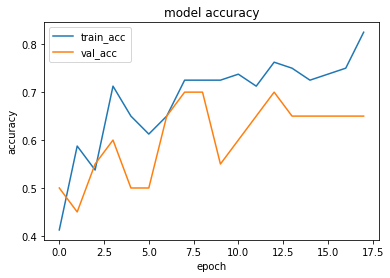

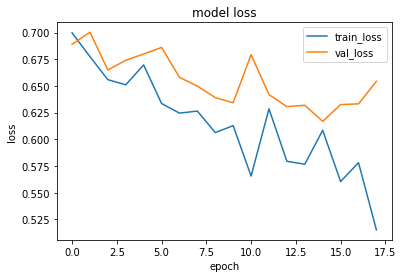

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.5469973]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.5637176]]


1it [00:00, 13025.79it/s]


prediction for video armflapping_2.mov is [[0.57804006]]


1it [00:00, 10082.46it/s]


prediction for video control_1.mov is [[0.39237654]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.33505]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.27053136]]


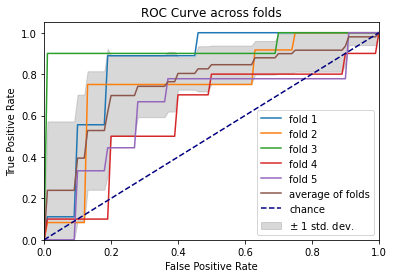

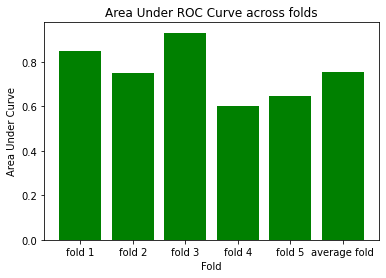

In [46]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 373ms/step - loss: 0.6781 - accuracy: 0.5750 - precision_157: 0.5636 - recall_157: 0.7561 - val_loss: 0.6722 - val_accuracy: 0.6500 - val_precision_157: 0.7500 - val_recall_157: 0.3333
Epoch 2/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6611 - accuracy: 0.6500 - precision_157: 0.7097 - recall_157: 0.5366 - val_loss: 0.6509 - val_accuracy: 0.5500 - val_precision_157: 0.5000 - val_recall_157: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6318 - accuracy: 0.6250 - precision_157: 0.5821 - recall_157: 0.9512 - val_loss: 0.5975 - val_accuracy: 0.8000 - val_precision_157: 0.7273 - val_recall_157: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6327 - accuracy: 0.6750 - precision_157: 0.7027 - recall_157: 0.6341 - val_loss: 0.5908 - val_accuracy: 0.8000 - val_precision_157: 0.7273 - val_recall_157: 0.8889
Epoch 5/75
3/3 [==============================] 

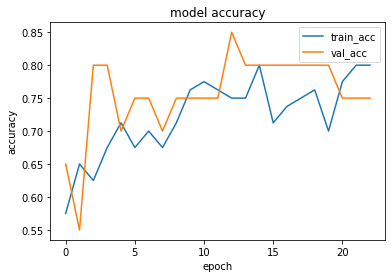

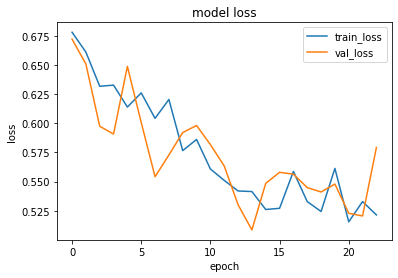

1it [00:00, 11915.64it/s]


prediction for video armflapping_1.mov is [[0.44603816]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.63792545]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.7138736]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.32022706]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.29507828]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.27526632]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.7075 - accuracy: 0.4125 - precision_158: 0.4211 - recall_158: 0.6316 - val_loss: 0.6853 - val_accuracy: 0.7000 - val_precision_158: 0.8000 - val_recall_158: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6718 - accuracy: 0.6500 - precision_158: 0.6389 - recall_158: 0.6053 - val_loss: 0.6943 - val_accuracy: 0.4000 - val_precision_158: 0.0000e+00 - val_recall_158: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6748 - accuracy: 0.5625 - precision_158: 0.6364 - recall_158: 0.1842 - val_loss: 0.7507 - val_accuracy: 0.4000 - val_precision_158: 0.0000e+00 - val_recall_158: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6598 - accuracy: 0.5625 - precision_158: 0.6667 - recall_158: 0.1579 - val_loss: 0.6870 - val_accuracy: 0.5000 - val_precision_158: 0.7500 - va

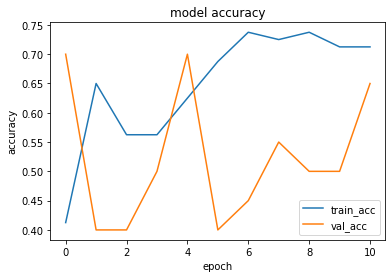

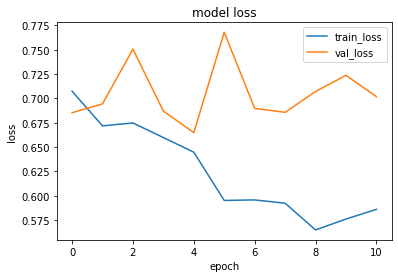

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.3974067]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5221968]]


1it [00:00, 10538.45it/s]


prediction for video armflapping_2.mov is [[0.6008087]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.2039567]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.18947247]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.19178951]]
Epoch 1/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6957 - accuracy: 0.4500 - precision_159: 0.4286 - recall_159: 0.3000 - val_loss: 0.6816 - val_accuracy: 0.8000 - val_precision_159: 0.8000 - val_recall_159: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6835 - accuracy: 0.5750 - precision_159: 0.5469 - recall_159: 0.8750 - val_loss: 0.6723 - val_accuracy: 0.5000 - val_precision_159: 0.5000 - val_recall_159: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6740 - accuracy: 0.5500 - precision_159: 0.5263 - recall_159: 1.0000 - val_loss: 0.6504 - val_accuracy: 0.7500 - val_precision_159: 0.6923 - val_recall_159: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6804 - accuracy: 0.6625 - precision_159: 0.6182 - recall_159: 0.8500 - val_loss: 0.6273 - val_accuracy: 0.8000 - val_precision_159: 0.8750 - val_recall_159: 0.

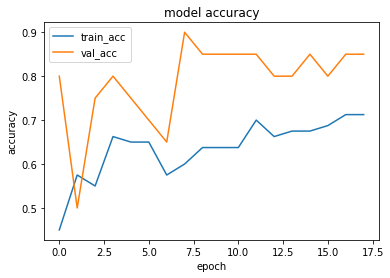

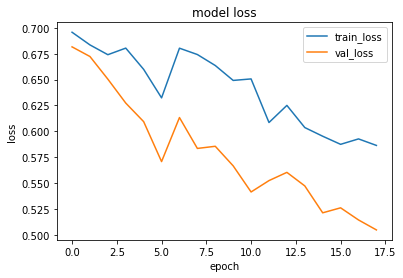

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.5099019]]


1it [00:00, 12483.05it/s]


prediction for video armflapping_3.mov is [[0.51499116]]


1it [00:00, 14217.98it/s]


prediction for video armflapping_2.mov is [[0.5485704]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.483732]]


1it [00:00, 13357.66it/s]


prediction for video control_2.mov is [[0.47050604]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.46496794]]
Epoch 1/75
3/3 [==============================] - 1s 316ms/step - loss: 0.7052 - accuracy: 0.5000 - precision_160: 0.5000 - recall_160: 0.5250 - val_loss: 0.6903 - val_accuracy: 0.5000 - val_precision_160: 0.5000 - val_recall_160: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6907 - accuracy: 0.5125 - precision_160: 0.5067 - recall_160: 0.9500 - val_loss: 0.6851 - val_accuracy: 0.5500 - val_precision_160: 0.5263 - val_recall_160: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6853 - accuracy: 0.4750 - precision_160: 0.4844 - recall_160: 0.7750 - val_loss: 0.6798 - val_accuracy: 0.6500 - val_precision_160: 0.6364 - val_recall_160: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6685 - accuracy: 0.7125 - precision_160: 0.7429 - recall_160: 0.6500 - val_loss: 0.6713 - val_accuracy: 0.6500 - val_precision_160: 0.6154 - val_recall_160: 0.

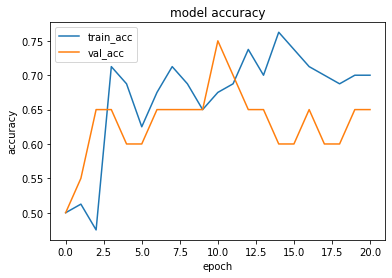

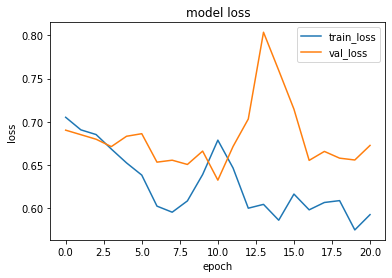

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.27183884]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.6310941]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.69328296]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.22094172]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.21056154]]


1it [00:00, 12945.38it/s]


prediction for video control_3.mov is [[0.2127845]]
Epoch 1/75
3/3 [==============================] - 1s 294ms/step - loss: 0.7122 - accuracy: 0.4125 - precision_161: 0.2857 - recall_161: 0.0976 - val_loss: 0.6915 - val_accuracy: 0.6000 - val_precision_161: 0.5333 - val_recall_161: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6851 - accuracy: 0.5000 - precision_161: 0.5072 - recall_161: 0.8537 - val_loss: 0.7000 - val_accuracy: 0.4500 - val_precision_161: 0.4500 - val_recall_161: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6819 - accuracy: 0.5375 - precision_161: 0.5256 - recall_161: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_precision_161: 0.4737 - val_recall_161: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6706 - accuracy: 0.5500 - precision_161: 0.5342 - recall_161: 0.9512 - val_loss: 0.6747 - val_accuracy: 0.6500 - val_precision_161: 0.5833 - val_recall_161: 0.7

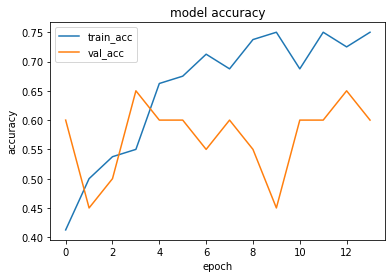

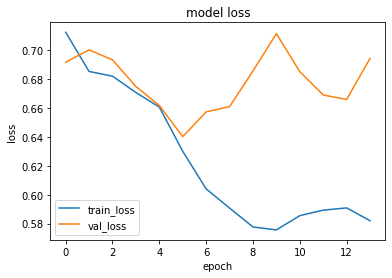

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.6005401]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.6877824]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.77176857]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.41152346]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.36467373]]


1it [00:00, 9709.04it/s]

prediction for video control_3.mov is [[0.26559305]]


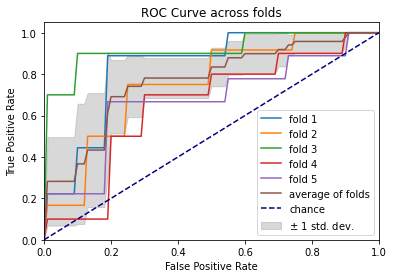

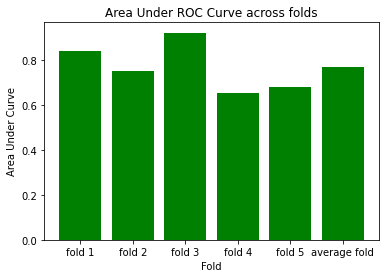

In [47]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 373ms/step - loss: 0.7033 - accuracy: 0.4875 - precision_163: 0.5000 - recall_163: 0.8780 - val_loss: 0.6867 - val_accuracy: 0.4500 - val_precision_163: 0.4500 - val_recall_163: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6516 - accuracy: 0.6625 - precision_163: 0.6207 - recall_163: 0.8780 - val_loss: 0.6735 - val_accuracy: 0.7000 - val_precision_163: 0.6154 - val_recall_163: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6918 - accuracy: 0.6625 - precision_163: 0.8182 - recall_163: 0.4390 - val_loss: 0.6553 - val_accuracy: 0.7500 - val_precision_163: 0.7000 - val_recall_163: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6466 - accuracy: 0.7250 - precision_163: 0.7879 - recall_163: 0.6341 - val_loss: 0.6527 - val_accuracy: 0.6500 - val_precision_163: 0.5714 - val_recall_163: 0.8889
Epoch 5/75
3/3 [==============================] 

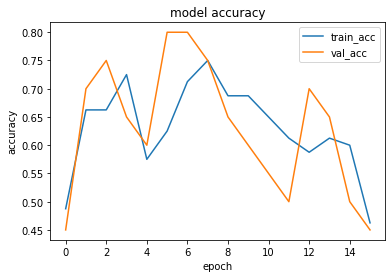

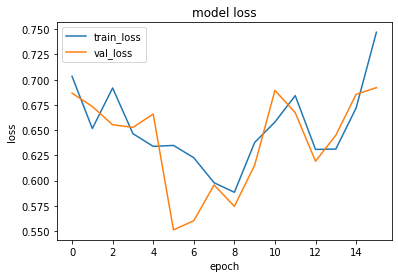

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.40226206]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_3.mov is [[0.53028935]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.5885245]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.31501824]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.29336268]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.30809474]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.7038 - accuracy: 0.4125 - precision_164: 0.3636 - recall_164: 0.3158 - val_loss: 0.6829 - val_accuracy: 0.5000 - val_precision_164: 0.7500 - val_recall_164: 0.2500
Epoch 2/75
3/3 [==============================] - 1s 317ms/step - loss: 0.6617 - accuracy: 0.7000 - precision_164: 0.6944 - recall_164: 0.6579 - val_loss: 0.5802 - val_accuracy: 0.7500 - val_precision_164: 0.8182 - val_recall_164: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6250 - accuracy: 0.6750 - precision_164: 0.6154 - recall_164: 0.8421 - val_loss: 0.7309 - val_accuracy: 0.5000 - val_precision_164: 1.0000 - val_recall_164: 0.1667
Epoch 4/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6259 - accuracy: 0.6375 - precision_164: 0.6452 - recall_164: 0.5263 - val_loss: 0.6520 - val_accuracy: 0.6500 - val_precision_164: 0.8571 - val_recall_164: 0.

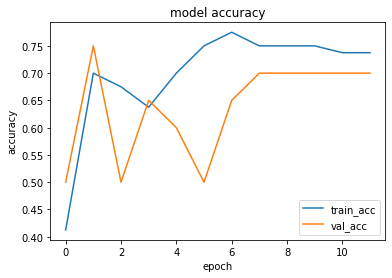

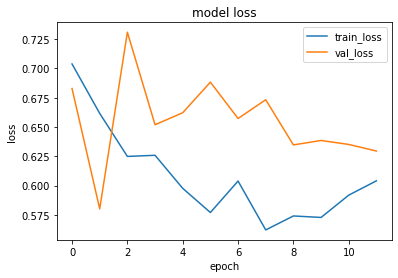

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.4752429]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.46610156]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.5515655]]


1it [00:00, 10538.45it/s]


prediction for video control_1.mov is [[0.43625623]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.40793458]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.41250786]]
Epoch 1/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6954 - accuracy: 0.6125 - precision_165: 0.6667 - recall_165: 0.4500 - val_loss: 0.6738 - val_accuracy: 0.6000 - val_precision_165: 0.5556 - val_recall_165: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 330ms/step - loss: 0.6864 - accuracy: 0.4875 - precision_165: 0.4928 - recall_165: 0.8500 - val_loss: 0.6487 - val_accuracy: 0.8000 - val_precision_165: 0.7500 - val_recall_165: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 314ms/step - loss: 0.6644 - accuracy: 0.6000 - precision_165: 0.5833 - recall_165: 0.7000 - val_loss: 0.5840 - val_accuracy: 0.8500 - val_precision_165: 0.8182 - val_recall_165: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6353 - accuracy: 0.7000 - precision_165: 0.6739 - recall_165: 0.7750 - val_loss: 0.4832 - val_accuracy: 0.7500 - val_precision_165: 0.6923 - val_recall_165: 0.

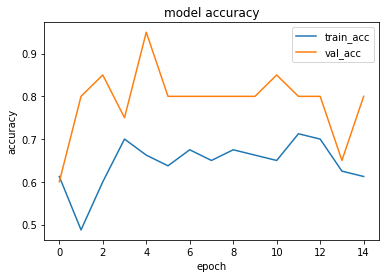

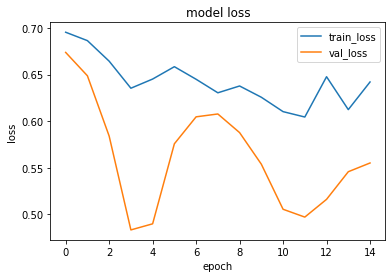

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.41755894]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_3.mov is [[0.45400608]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_2.mov is [[0.5069202]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.38693836]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.37823123]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.3754869]]
Epoch 1/75
3/3 [==============================] - 1s 322ms/step - loss: 0.7019 - accuracy: 0.4375 - precision_166: 0.4138 - recall_166: 0.3000 - val_loss: 0.6864 - val_accuracy: 0.5000 - val_precision_166: 0.0000e+00 - val_recall_166: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 354ms/step - loss: 0.6804 - accuracy: 0.5875 - precision_166: 0.8889 - recall_166: 0.2000 - val_loss: 0.6656 - val_accuracy: 0.6500 - val_precision_166: 0.6154 - val_recall_166: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6415 - accuracy: 0.6625 - precision_166: 0.6066 - recall_166: 0.9250 - val_loss: 0.6470 - val_accuracy: 0.5500 - val_precision_166: 0.5294 - val_recall_166: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6253 - accuracy: 0.6250 - precision_166: 0.5781 - recall_166: 0.9250 - val_loss: 0.6579 - val_accuracy: 0.6000 - val_precision_166: 0.6250 - val_recall_

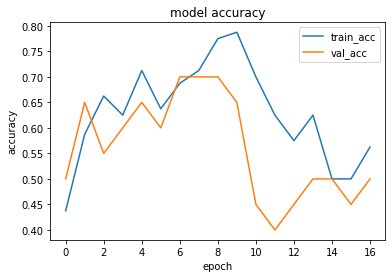

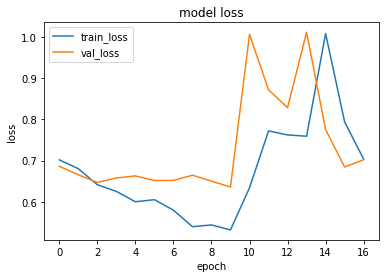

1it [00:00, 13662.23it/s]


prediction for video armflapping_1.mov is [[0.5791867]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5969651]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.5939438]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.5739582]]


1it [00:00, 12633.45it/s]


prediction for video control_2.mov is [[0.57108235]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.5708317]]
Epoch 1/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6812 - accuracy: 0.5625 - precision_167: 0.5500 - recall_167: 0.8049 - val_loss: 0.6823 - val_accuracy: 0.5000 - val_precision_167: 0.4737 - val_recall_167: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6584 - accuracy: 0.6250 - precision_167: 0.5846 - recall_167: 0.9268 - val_loss: 0.6715 - val_accuracy: 0.5000 - val_precision_167: 0.4737 - val_recall_167: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 282ms/step - loss: 0.6145 - accuracy: 0.6375 - precision_167: 0.6000 - recall_167: 0.8780 - val_loss: 0.8831 - val_accuracy: 0.5000 - val_precision_167: 0.4706 - val_recall_167: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 284ms/step - loss: 0.7105 - accuracy: 0.5875 - precision_167: 0.5870 - recall_167: 0.6585 - val_loss: 0.6391 - val_accuracy: 0.7000 - val_precision_167: 0.6667 - val_recall_167: 0.6

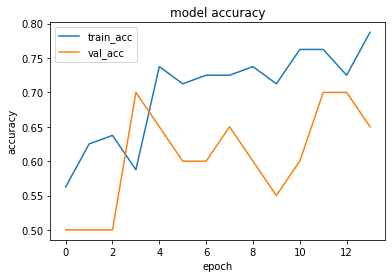

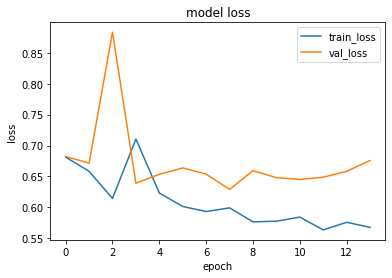

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.54502]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.63852]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.7051997]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.33275944]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.24066424]]


1it [00:00, 18315.74it/s]


prediction for video control_3.mov is [[0.26674306]]


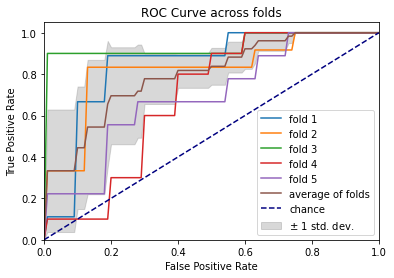

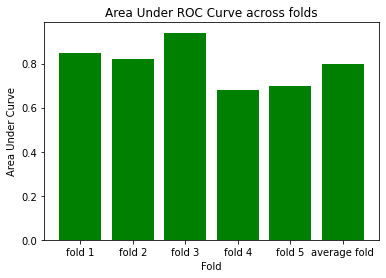

In [48]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6935 - accuracy: 0.4250 - precision_169: 0.4138 - recall_169: 0.2927 - val_loss: 0.6898 - val_accuracy: 0.4500 - val_precision_169: 0.4375 - val_recall_169: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6735 - accuracy: 0.5250 - precision_169: 0.5195 - recall_169: 0.9756 - val_loss: 0.6817 - val_accuracy: 0.4500 - val_precision_169: 0.4500 - val_recall_169: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 397ms/step - loss: 0.6554 - accuracy: 0.5500 - precision_169: 0.5333 - recall_169: 0.9756 - val_loss: 0.6612 - val_accuracy: 0.5500 - val_precision_169: 0.5000 - val_recall_169: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6349 - accuracy: 0.6250 - precision_169: 0.5873 - recall_169: 0.9024 - val_loss: 0.6304 - val_accuracy: 0.8000 - val_precision_169: 0.7273 - val_recall_169: 0.8889
Epoch 5/75
3/3 [==============================] 

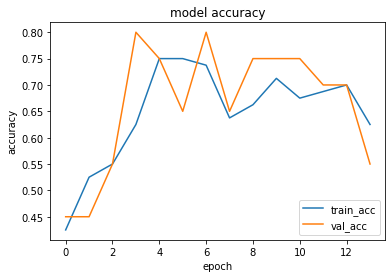

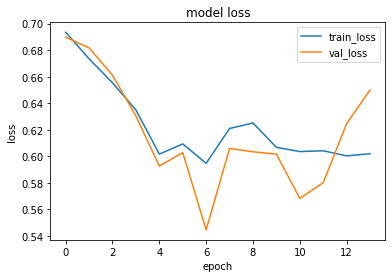

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.50481695]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.51253504]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.5402632]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.49140885]]


1it [00:00, 12985.46it/s]


prediction for video control_2.mov is [[0.48067454]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.4806027]]
Epoch 1/75
3/3 [==============================] - 1s 372ms/step - loss: 0.6890 - accuracy: 0.6625 - precision_170: 0.6897 - recall_170: 0.5263 - val_loss: 0.6755 - val_accuracy: 0.6500 - val_precision_170: 0.7273 - val_recall_170: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6810 - accuracy: 0.6500 - precision_170: 0.6000 - recall_170: 0.7895 - val_loss: 0.6545 - val_accuracy: 0.6500 - val_precision_170: 0.7778 - val_recall_170: 0.5833
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6457 - accuracy: 0.7125 - precision_170: 0.6531 - recall_170: 0.8421 - val_loss: 0.6855 - val_accuracy: 0.5500 - val_precision_170: 1.0000 - val_recall_170: 0.2500
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6063 - accuracy: 0.7500 - precision_170: 0.7500 - recall_170: 0.7105 - val_loss: 0.8333 - val_accuracy: 0.5000 - val_precision_170: 1.0000 - val_recall_170: 0.1

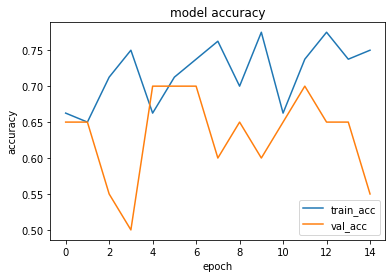

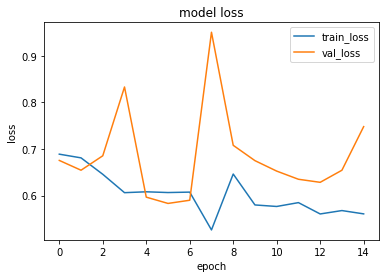

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.30530775]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.48403424]]


1it [00:00, 12520.31it/s]


prediction for video armflapping_2.mov is [[0.6188064]]


1it [00:00, 5777.28it/s]


prediction for video control_1.mov is [[0.265186]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.25748193]]


1it [00:00, 12336.19it/s]


prediction for video control_3.mov is [[0.2621475]]
Epoch 1/75
3/3 [==============================] - 1s 418ms/step - loss: 0.7027 - accuracy: 0.5625 - precision_171: 0.5472 - recall_171: 0.7250 - val_loss: 0.6876 - val_accuracy: 0.7000 - val_precision_171: 0.6667 - val_recall_171: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 445ms/step - loss: 0.6853 - accuracy: 0.5875 - precision_171: 0.5946 - recall_171: 0.5500 - val_loss: 0.6742 - val_accuracy: 0.7500 - val_precision_171: 0.7273 - val_recall_171: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 400ms/step - loss: 0.6752 - accuracy: 0.6750 - precision_171: 0.6667 - recall_171: 0.7000 - val_loss: 0.6652 - val_accuracy: 0.7500 - val_precision_171: 0.7273 - val_recall_171: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 390ms/step - loss: 0.6620 - accuracy: 0.6875 - precision_171: 0.6596 - recall_171: 0.7750 - val_loss: 0.6280 - val_accuracy: 0.8000 - val_precision_171: 0.8000 - val_recall_171: 0.8

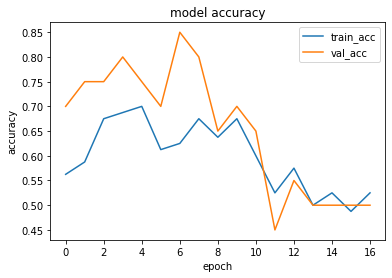

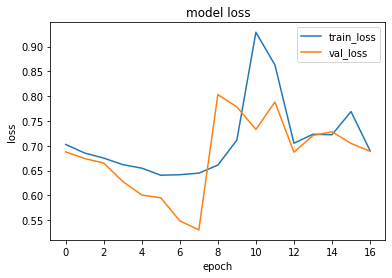

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.44763556]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.4884146]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.49472922]]


1it [00:00, 13357.66it/s]


prediction for video control_1.mov is [[0.41604632]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.403264]]


1it [00:00, 16644.06it/s]


prediction for video control_3.mov is [[0.40193015]]
Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6874 - accuracy: 0.5250 - precision_172: 0.5312 - recall_172: 0.4250 - val_loss: 0.6816 - val_accuracy: 0.6000 - val_precision_172: 1.0000 - val_recall_172: 0.2000
Epoch 2/75
3/3 [==============================] - 1s 373ms/step - loss: 0.6482 - accuracy: 0.7250 - precision_172: 0.7647 - recall_172: 0.6500 - val_loss: 0.6638 - val_accuracy: 0.6000 - val_precision_172: 0.5625 - val_recall_172: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6400 - accuracy: 0.6000 - precision_172: 0.5625 - recall_172: 0.9000 - val_loss: 0.7367 - val_accuracy: 0.6000 - val_precision_172: 0.6667 - val_recall_172: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 303ms/step - loss: 0.5821 - accuracy: 0.7125 - precision_172: 0.8400 - recall_172: 0.5250 - val_loss: 0.6604 - val_accuracy: 0.6500 - val_precision_172: 0.7143 - val_recall_172: 0.

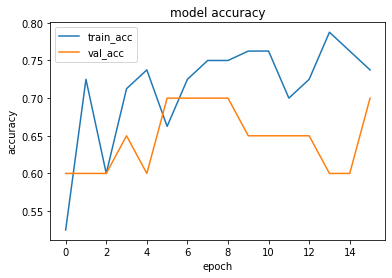

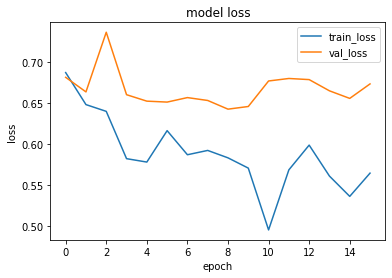

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.2902107]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.59470403]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.6210344]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.20304391]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.18969256]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.18757004]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6864 - accuracy: 0.5250 - precision_173: 0.5306 - recall_173: 0.6341 - val_loss: 0.6935 - val_accuracy: 0.5500 - val_precision_173: 0.5000 - val_recall_173: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6636 - accuracy: 0.6500 - precision_173: 0.6182 - recall_173: 0.8293 - val_loss: 0.6750 - val_accuracy: 0.6500 - val_precision_173: 0.5833 - val_recall_173: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6409 - accuracy: 0.6250 - precision_173: 0.6410 - recall_173: 0.6098 - val_loss: 0.7673 - val_accuracy: 0.6500 - val_precision_173: 0.5625 - val_recall_173: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 317ms/step - loss: 0.6286 - accuracy: 0.6625 - precision_173: 0.6250 - recall_173: 0.8537 - val_loss: 0.6285 - val_accuracy: 0.7000 - val_precision_173: 0.6667 - val_recall_173: 0.

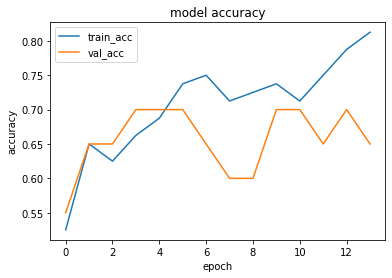

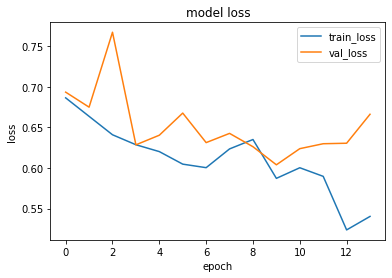

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.59364074]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.6732484]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.7153019]]


1it [00:00, 15252.01it/s]


prediction for video control_1.mov is [[0.4381923]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.39257312]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.36260802]]


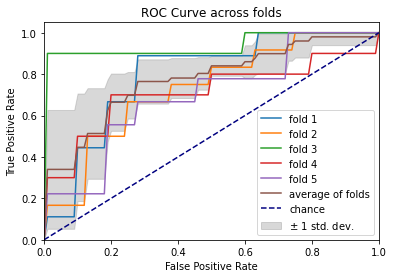

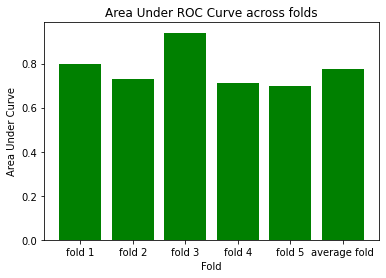

In [49]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6987 - accuracy: 0.4250 - precision_175: 0.4324 - recall_175: 0.3902 - val_loss: 0.6948 - val_accuracy: 0.5000 - val_precision_175: 0.4737 - val_recall_175: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6897 - accuracy: 0.4375 - precision_175: 0.4630 - recall_175: 0.6098 - val_loss: 0.6853 - val_accuracy: 0.5500 - val_precision_175: 0.5000 - val_recall_175: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 386ms/step - loss: 0.6716 - accuracy: 0.5750 - precision_175: 0.5614 - recall_175: 0.7805 - val_loss: 0.6657 - val_accuracy: 0.5500 - val_precision_175: 0.5000 - val_recall_175: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6459 - accuracy: 0.5750 - precision_175: 0.5538 - recall_175: 0.8780 - val_loss: 0.6798 - val_accuracy: 0.4500 - val_precision_175: 0.4500 - val_recall_175: 1.0000
Epoch 5/75
3/3 [==============================] 

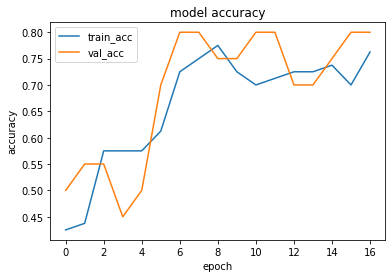

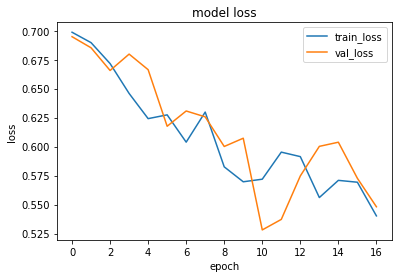

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.50360656]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.52953976]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.53830874]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.48643234]]


1it [00:00, 14217.98it/s]


prediction for video control_2.mov is [[0.47510472]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.47546652]]
Epoch 1/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6923 - accuracy: 0.5375 - precision_176: 0.5143 - recall_176: 0.4737 - val_loss: 0.6679 - val_accuracy: 0.7000 - val_precision_176: 0.8750 - val_recall_176: 0.5833
Epoch 2/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6543 - accuracy: 0.7375 - precision_176: 0.6977 - recall_176: 0.7895 - val_loss: 0.6350 - val_accuracy: 0.7000 - val_precision_176: 0.8000 - val_recall_176: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6353 - accuracy: 0.6625 - precision_176: 0.6571 - recall_176: 0.6053 - val_loss: 0.7240 - val_accuracy: 0.5500 - val_precision_176: 1.0000 - val_recall_176: 0.2500
Epoch 4/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6082 - accuracy: 0.7250 - precision_176: 0.7857 - recall_176: 0.5789 - val_loss: 0.6114 - val_accuracy: 0.7000 - val_precision_176: 0.8750 - val_recall_176: 0.

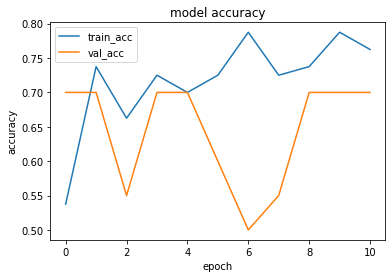

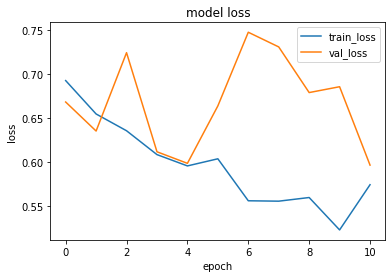

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.60116374]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_3.mov is [[0.6693215]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_2.mov is [[0.7410146]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.45634198]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.41661108]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.25561303]]
Epoch 1/75
3/3 [==============================] - 1s 379ms/step - loss: 0.7157 - accuracy: 0.3625 - precision_177: 0.3514 - recall_177: 0.3250 - val_loss: 0.6914 - val_accuracy: 0.7000 - val_precision_177: 0.6667 - val_recall_177: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 367ms/step - loss: 0.6806 - accuracy: 0.6250 - precision_177: 0.6250 - recall_177: 0.6250 - val_loss: 0.6735 - val_accuracy: 0.7000 - val_precision_177: 0.7000 - val_recall_177: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 385ms/step - loss: 0.6725 - accuracy: 0.6375 - precision_177: 0.7391 - recall_177: 0.4250 - val_loss: 0.6261 - val_accuracy: 0.7000 - val_precision_177: 1.0000 - val_recall_177: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 447ms/step - loss: 0.6579 - accuracy: 0.6125 - precision_177: 0.6800 - recall_177: 0.4250 - val_loss: 0.5697 - val_accuracy: 0.6000 - val_precision_177: 0.5625 - val_recall_177: 0.

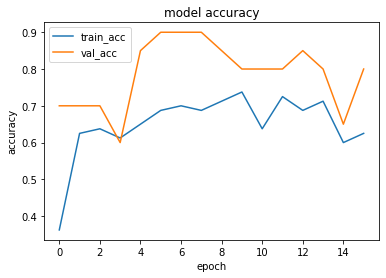

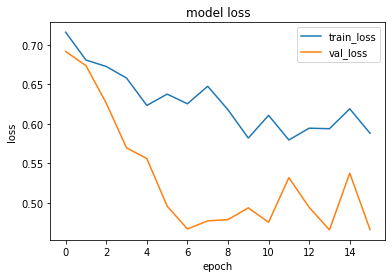

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.48130456]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_3.mov is [[0.49069667]]


1it [00:00, 12633.45it/s]


prediction for video armflapping_2.mov is [[0.5134769]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.46538094]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.46021947]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.45670566]]
Epoch 1/75
3/3 [==============================] - 1s 375ms/step - loss: 0.6821 - accuracy: 0.5500 - precision_178: 0.5625 - recall_178: 0.4500 - val_loss: 0.6709 - val_accuracy: 0.5500 - val_precision_178: 0.5294 - val_recall_178: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6510 - accuracy: 0.6250 - precision_178: 0.5758 - recall_178: 0.9500 - val_loss: 0.6558 - val_accuracy: 0.7000 - val_precision_178: 0.6667 - val_recall_178: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6309 - accuracy: 0.6750 - precision_178: 0.6750 - recall_178: 0.6750 - val_loss: 0.6693 - val_accuracy: 0.6000 - val_precision_178: 0.6250 - val_recall_178: 0.5000
Epoch 4/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6208 - accuracy: 0.6750 - precision_178: 0.7917 - recall_178: 0.4750 - val_loss: 0.6705 - val_accuracy: 0.5500 - val_precision_178: 0.5455 - val_recall_178: 0.

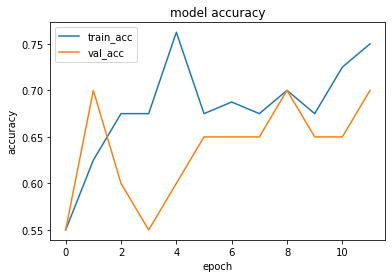

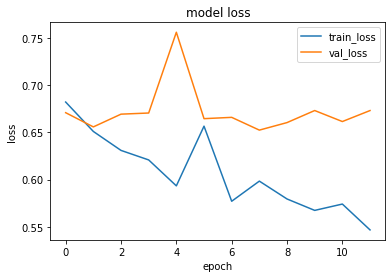

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5234411]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.57528657]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.6351486]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.46263844]]


1it [00:00, 11275.01it/s]


prediction for video control_2.mov is [[0.4373031]]


1it [00:00, 13662.23it/s]


prediction for video control_3.mov is [[0.41855296]]
Epoch 1/75
3/3 [==============================] - 1s 367ms/step - loss: 0.7152 - accuracy: 0.4875 - precision_179: 0.5000 - recall_179: 0.9268 - val_loss: 0.6941 - val_accuracy: 0.4500 - val_precision_179: 0.4500 - val_recall_179: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 361ms/step - loss: 0.6724 - accuracy: 0.5500 - precision_179: 0.5362 - recall_179: 0.9024 - val_loss: 0.6784 - val_accuracy: 0.6500 - val_precision_179: 0.7500 - val_recall_179: 0.3333
Epoch 3/75
3/3 [==============================] - 1s 369ms/step - loss: 0.6692 - accuracy: 0.6750 - precision_179: 0.8261 - recall_179: 0.4634 - val_loss: 0.6702 - val_accuracy: 0.6500 - val_precision_179: 0.7500 - val_recall_179: 0.3333
Epoch 4/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6655 - accuracy: 0.6500 - precision_179: 0.6970 - recall_179: 0.5610 - val_loss: 0.6539 - val_accuracy: 0.6000 - val_precision_179: 0.5556 - val_recall_179: 0.

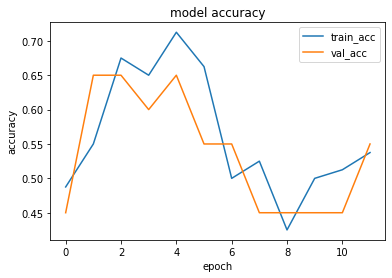

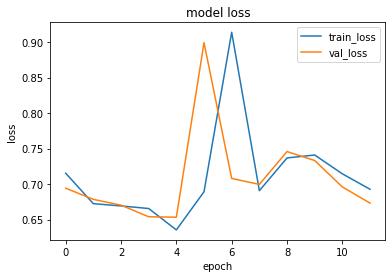

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.44572103]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.4722837]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.46495092]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.43465328]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.4299675]]


1it [00:00, 13934.56it/s]


prediction for video control_3.mov is [[0.42928487]]


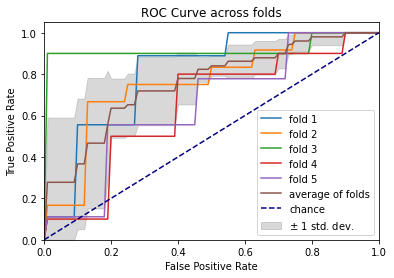

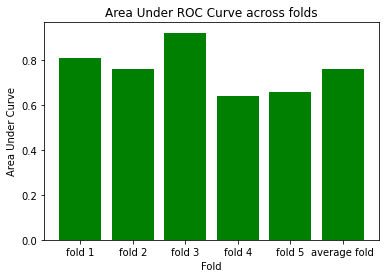

In [50]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 372ms/step - loss: 0.6943 - accuracy: 0.4000 - precision_181: 0.3939 - recall_181: 0.3171 - val_loss: 0.6895 - val_accuracy: 0.5000 - val_precision_181: 0.4737 - val_recall_181: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6719 - accuracy: 0.5375 - precision_181: 0.5286 - recall_181: 0.9024 - val_loss: 0.6846 - val_accuracy: 0.5000 - val_precision_181: 0.4737 - val_recall_181: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 369ms/step - loss: 0.6657 - accuracy: 0.5375 - precision_181: 0.5278 - recall_181: 0.9268 - val_loss: 0.6591 - val_accuracy: 0.5500 - val_precision_181: 0.5000 - val_recall_181: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 375ms/step - loss: 0.6295 - accuracy: 0.6250 - precision_181: 0.5846 - recall_181: 0.9268 - val_loss: 0.5884 - val_accuracy: 0.7500 - val_precision_181: 0.6667 - val_recall_181: 0.8889
Epoch 5/75
3/3 [==============================] 

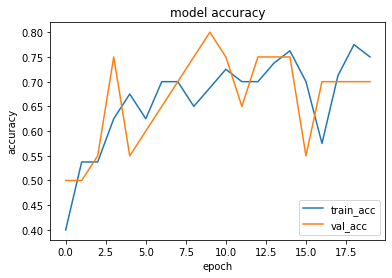

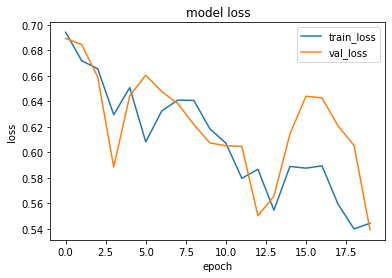

1it [00:00, 3226.39it/s]


prediction for video armflapping_1.mov is [[0.43309543]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.51831555]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.5246875]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.35134354]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.3239628]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.30923453]]
Epoch 1/75
3/3 [==============================] - 1s 377ms/step - loss: 0.6871 - accuracy: 0.4875 - precision_182: 0.4805 - recall_182: 0.9737 - val_loss: 0.6682 - val_accuracy: 0.7000 - val_precision_182: 0.8750 - val_recall_182: 0.5833
Epoch 2/75
3/3 [==============================] - 1s 387ms/step - loss: 0.6719 - accuracy: 0.6250 - precision_182: 0.6429 - recall_182: 0.4737 - val_loss: 0.6829 - val_accuracy: 0.5000 - val_precision_182: 1.0000 - val_recall_182: 0.1667
Epoch 3/75
3/3 [==============================] - 1s 376ms/step - loss: 0.6438 - accuracy: 0.6375 - precision_182: 0.8462 - recall_182: 0.2895 - val_loss: 0.6775 - val_accuracy: 0.5500 - val_precision_182: 0.8000 - val_recall_182: 0.3333
Epoch 4/75
3/3 [==============================] - 1s 367ms/step - loss: 0.6426 - accuracy: 0.6500 - precision_182: 0.6190 - recall_182: 0.6842 - val_loss: 0.6083 - val_accuracy: 0.7000 - val_precision_182: 0.8000 - val_recall_182: 0.

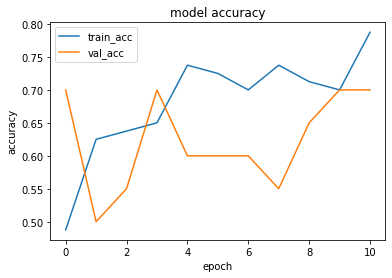

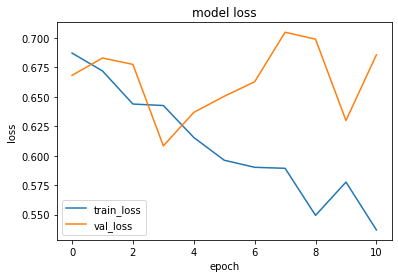

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.45811135]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.50772285]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.56327057]]


1it [00:00, 2985.27it/s]


prediction for video control_1.mov is [[0.24646157]]


1it [00:00, 11491.24it/s]


prediction for video control_2.mov is [[0.17700171]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.21909139]]
Epoch 1/75
3/3 [==============================] - 1s 372ms/step - loss: 0.6927 - accuracy: 0.4625 - precision_183: 0.4706 - recall_183: 0.6000 - val_loss: 0.6587 - val_accuracy: 0.6000 - val_precision_183: 0.5556 - val_recall_183: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6804 - accuracy: 0.5250 - precision_183: 0.5135 - recall_183: 0.9500 - val_loss: 0.6352 - val_accuracy: 0.8500 - val_precision_183: 0.8182 - val_recall_183: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6690 - accuracy: 0.5750 - precision_183: 0.6071 - recall_183: 0.4250 - val_loss: 0.5696 - val_accuracy: 0.9500 - val_precision_183: 1.0000 - val_recall_183: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 365ms/step - loss: 0.6558 - accuracy: 0.5750 - precision_183: 0.5536 - recall_183: 0.7750 - val_loss: 0.5418 - val_accuracy: 0.6500 - val_precision_183: 0.6000 - val_recall_183: 0.

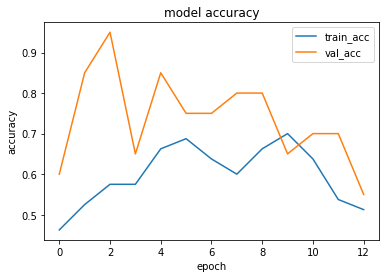

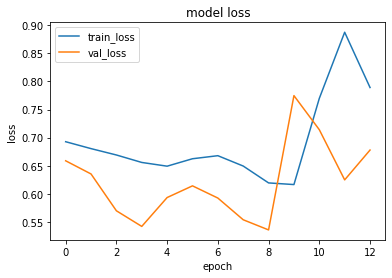

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.48686594]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.49538243]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.50137943]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.47630334]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.4730623]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.46939677]]
Epoch 1/75
3/3 [==============================] - 1s 374ms/step - loss: 0.6930 - accuracy: 0.4750 - precision_184: 0.4762 - recall_184: 0.5000 - val_loss: 0.6843 - val_accuracy: 0.6500 - val_precision_184: 0.6000 - val_recall_184: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 392ms/step - loss: 0.6488 - accuracy: 0.6750 - precision_184: 0.6400 - recall_184: 0.8000 - val_loss: 0.6762 - val_accuracy: 0.6500 - val_precision_184: 0.6364 - val_recall_184: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 365ms/step - loss: 0.6339 - accuracy: 0.7125 - precision_184: 0.6667 - recall_184: 0.8500 - val_loss: 0.6966 - val_accuracy: 0.4500 - val_precision_184: 0.0000e+00 - val_recall_184: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 1s 366ms/step - loss: 0.6776 - accuracy: 0.5250 - precision_184: 0.7500 - recall_184: 0.0750 - val_loss: 0.6994 - val_accuracy: 0.5000 - val_precision_184: 0.0000e+00 - val_re

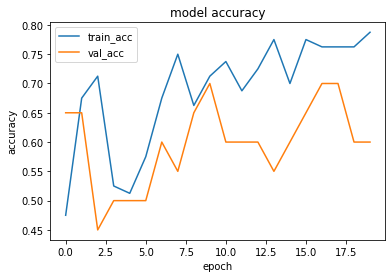

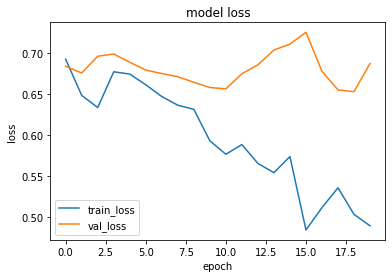

1it [00:00, 17260.51it/s]


prediction for video armflapping_1.mov is [[0.4369221]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.6427415]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.68778694]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.3079942]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.28003085]]


1it [00:00, 12192.74it/s]


prediction for video control_3.mov is [[0.28653574]]
Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.7044 - accuracy: 0.4250 - precision_185: 0.0000e+00 - recall_185: 0.0000e+00 - val_loss: 0.6935 - val_accuracy: 0.5500 - val_precision_185: 0.5000 - val_recall_185: 0.5556
Epoch 2/75
3/3 [==============================] - 1s 361ms/step - loss: 0.6954 - accuracy: 0.4625 - precision_185: 0.4792 - recall_185: 0.5610 - val_loss: 0.6928 - val_accuracy: 0.5000 - val_precision_185: 0.4737 - val_recall_185: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 395ms/step - loss: 0.6712 - accuracy: 0.5750 - precision_185: 0.5538 - recall_185: 0.8780 - val_loss: 0.7017 - val_accuracy: 0.4500 - val_precision_185: 0.4500 - val_recall_185: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 441ms/step - loss: 0.6569 - accuracy: 0.6250 - precision_185: 0.5821 - recall_185: 0.9512 - val_loss: 0.6930 - val_accuracy: 0.6500 - val_precision_185: 0.5714 - val_recall

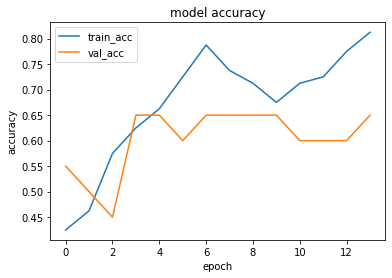

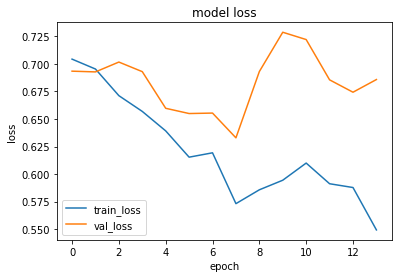

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.6014309]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.69487435]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.7600051]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.37610418]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.30260304]]


1it [00:00, 13486.51it/s]


prediction for video control_3.mov is [[0.28819746]]


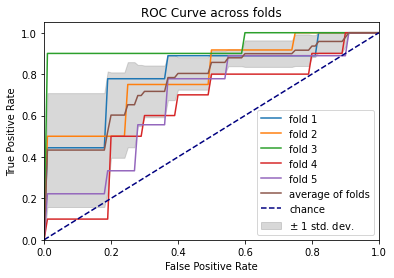

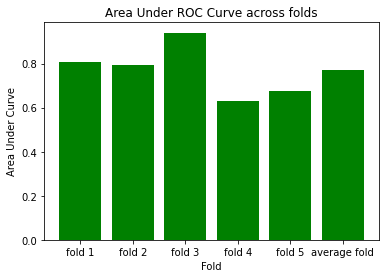

In [51]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 374ms/step - loss: 0.7018 - accuracy: 0.3625 - precision_187: 0.3611 - recall_187: 0.3171 - val_loss: 0.6977 - val_accuracy: 0.5000 - val_precision_187: 0.4737 - val_recall_187: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 359ms/step - loss: 0.6896 - accuracy: 0.5000 - precision_187: 0.5077 - recall_187: 0.8049 - val_loss: 0.6917 - val_accuracy: 0.5000 - val_precision_187: 0.4737 - val_recall_187: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6662 - accuracy: 0.5625 - precision_187: 0.5417 - recall_187: 0.9512 - val_loss: 0.7087 - val_accuracy: 0.4500 - val_precision_187: 0.4500 - val_recall_187: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 360ms/step - loss: 0.6883 - accuracy: 0.5500 - precision_187: 0.5325 - recall_187: 1.0000 - val_loss: 0.6790 - val_accuracy: 0.4500 - val_precision_187: 0.4500 - val_recall_187: 1.0000
Epoch 5/75
3/3 [==============================] 

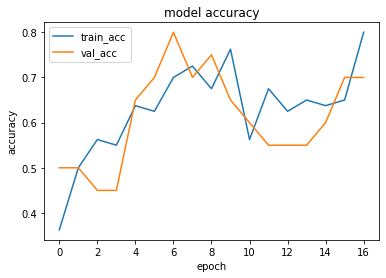

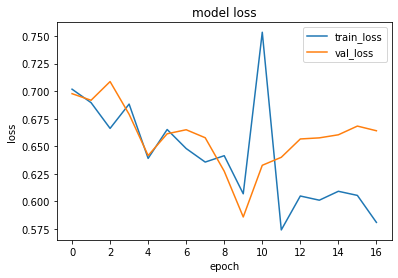

1it [00:00, 17260.51it/s]


prediction for video armflapping_1.mov is [[0.4984762]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.51837987]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.517613]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.48852408]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.4837943]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.4833539]]
Epoch 1/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6891 - accuracy: 0.5875 - precision_188: 0.6667 - recall_188: 0.2632 - val_loss: 0.6675 - val_accuracy: 0.7000 - val_precision_188: 0.8750 - val_recall_188: 0.5833
Epoch 2/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6787 - accuracy: 0.6125 - precision_188: 0.5614 - recall_188: 0.8421 - val_loss: 0.6550 - val_accuracy: 0.7000 - val_precision_188: 0.8750 - val_recall_188: 0.5833
Epoch 3/75
3/3 [==============================] - 1s 434ms/step - loss: 0.6505 - accuracy: 0.6750 - precision_188: 0.6429 - recall_188: 0.7105 - val_loss: 0.6837 - val_accuracy: 0.5000 - val_precision_188: 1.0000 - val_recall_188: 0.1667
Epoch 4/75
3/3 [==============================] - 1s 360ms/step - loss: 0.6424 - accuracy: 0.6125 - precision_188: 0.7333 - recall_188: 0.2895 - val_loss: 0.6977 - val_accuracy: 0.4500 - val_precision_188: 0.6667 - val_recall_188: 0.1

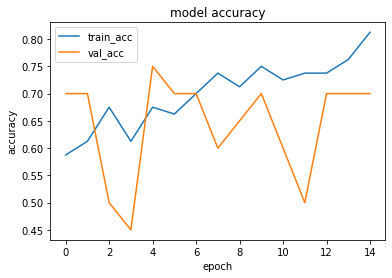

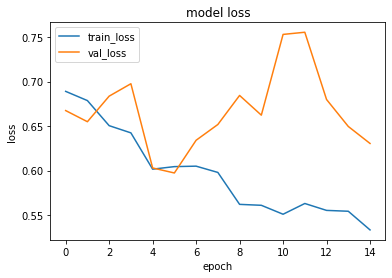

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.46411112]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.54425204]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.59324956]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.460251]]


1it [00:00, 14027.77it/s]


prediction for video control_2.mov is [[0.43584722]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.44444913]]
Epoch 1/75
3/3 [==============================] - 1s 373ms/step - loss: 0.6859 - accuracy: 0.5375 - precision_189: 0.5246 - recall_189: 0.8000 - val_loss: 0.6722 - val_accuracy: 0.5000 - val_precision_189: 0.5000 - val_recall_189: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 366ms/step - loss: 0.6773 - accuracy: 0.5875 - precision_189: 0.5593 - recall_189: 0.8250 - val_loss: 0.6450 - val_accuracy: 0.8000 - val_precision_189: 0.8750 - val_recall_189: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 366ms/step - loss: 0.6694 - accuracy: 0.6125 - precision_189: 0.6552 - recall_189: 0.4750 - val_loss: 0.6255 - val_accuracy: 0.8000 - val_precision_189: 0.8000 - val_recall_189: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6553 - accuracy: 0.6500 - precision_189: 0.6875 - recall_189: 0.5500 - val_loss: 0.5763 - val_accuracy: 0.8000 - val_precision_189: 0.8000 - val_recall_189: 0.

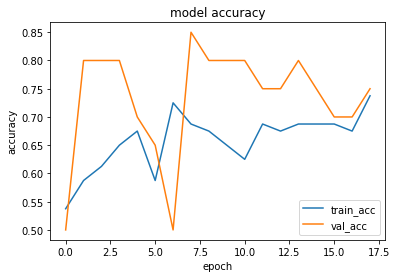

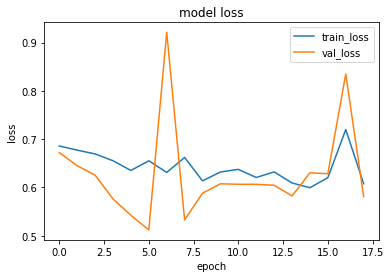

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.4760782]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.52967244]]


1it [00:00, 14217.98it/s]


prediction for video armflapping_2.mov is [[0.5468918]]


1it [00:00, 12372.58it/s]


prediction for video control_1.mov is [[0.41183046]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.3850104]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.37399155]]
Epoch 1/75
3/3 [==============================] - 1s 371ms/step - loss: 0.6990 - accuracy: 0.4750 - precision_190: 0.4861 - recall_190: 0.8750 - val_loss: 0.6877 - val_accuracy: 0.5000 - val_precision_190: 0.5000 - val_recall_190: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6820 - accuracy: 0.5375 - precision_190: 0.5333 - recall_190: 0.6000 - val_loss: 0.6775 - val_accuracy: 0.7000 - val_precision_190: 0.7000 - val_recall_190: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 408ms/step - loss: 0.6795 - accuracy: 0.5500 - precision_190: 0.5400 - recall_190: 0.6750 - val_loss: 0.6730 - val_accuracy: 0.5000 - val_precision_190: 0.5000 - val_recall_190: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 369ms/step - loss: 0.6636 - accuracy: 0.5000 - precision_190: 0.5000 - recall_190: 0.8000 - val_loss: 0.6594 - val_accuracy: 0.7000 - val_precision_190: 0.6667 - val_recall_190: 0.

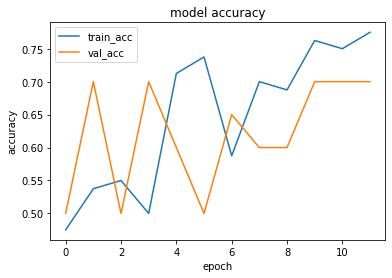

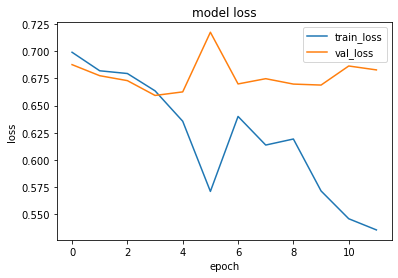

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.45051426]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.51934695]]


1it [00:00, 8144.28it/s]


prediction for video armflapping_2.mov is [[0.60328275]]


1it [00:00, 10645.44it/s]


prediction for video control_1.mov is [[0.36396956]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.3335911]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.3212462]]
Epoch 1/75
3/3 [==============================] - 1s 413ms/step - loss: 0.6925 - accuracy: 0.5250 - precision_191: 0.5882 - recall_191: 0.2439 - val_loss: 0.6770 - val_accuracy: 0.5000 - val_precision_191: 0.4737 - val_recall_191: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 477ms/step - loss: 0.6961 - accuracy: 0.5250 - precision_191: 0.5200 - recall_191: 0.9512 - val_loss: 0.6689 - val_accuracy: 0.5000 - val_precision_191: 0.4737 - val_recall_191: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 448ms/step - loss: 0.6410 - accuracy: 0.5875 - precision_191: 0.5571 - recall_191: 0.9512 - val_loss: 0.6615 - val_accuracy: 0.5500 - val_precision_191: 0.5000 - val_recall_191: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 429ms/step - loss: 0.6094 - accuracy: 0.6250 - precision_191: 0.5846 - recall_191: 0.9268 - val_loss: 0.8242 - val_accuracy: 0.4500 - val_precision_191: 0.4444 - val_recall_191: 0.8

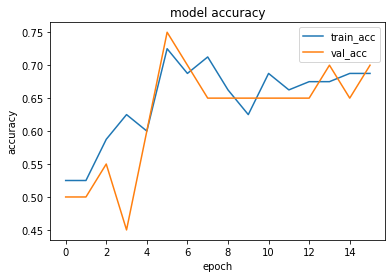

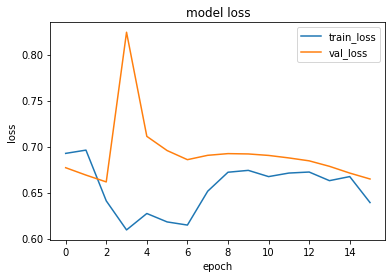

1it [00:00, 11491.24it/s]


prediction for video armflapping_1.mov is [[0.4737124]]


1it [00:00, 11781.75it/s]


prediction for video armflapping_3.mov is [[0.48179317]]


1it [00:00, 8388.61it/s]


prediction for video armflapping_2.mov is [[0.49943185]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.4518805]]


1it [00:00, 12192.74it/s]


prediction for video control_2.mov is [[0.44187802]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.440008]]


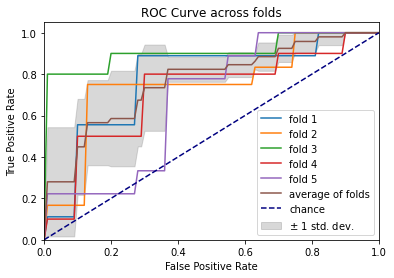

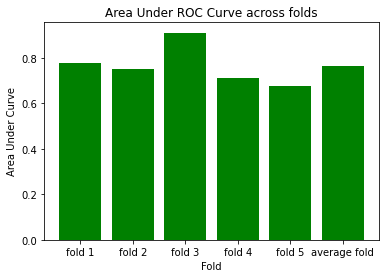

In [52]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

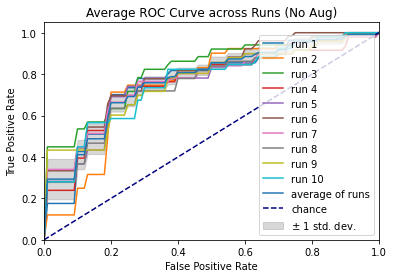

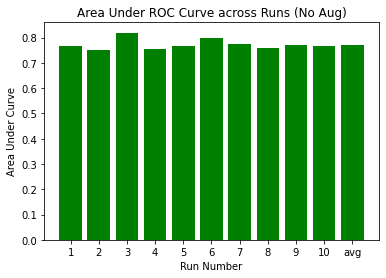

In [53]:
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) 

In [54]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7721050505050505, 0.019019810701396942)